# Primerjava pristopov za luščenje ključnih besed na povzetkih člankov s ključno besedo "Longevity"

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora povzetkov člankov s ključno besedo "Longevity" v zbirki PubMed.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [1]:
import string
import ast

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
import yake
import rake

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

from bert_keyword_extractor import TransformerKeywordExtractor

Naložimo metapodatke in dokumente iz zbirke in dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

df = pd.read_pickle("data/pubmed_longevity.pkl")
len_before = len(df)
# izpusti članke brez ključnih besed
df = df[~df["keywords"].isnull()]

# ne lematiziramo, ker so izhodiščne besede že korenjene (Porter Stemmer)
df["Keywords_one_word"] = df["keywords"].apply(
    lambda ph: [w.strip('][ )') for p in ph if p is not None for w in p.split()]
)

tokens_list = preprocess(df["abstract"])

print(f"Število dokumentov: {len(df)}/{len_before}")

Število dokumentov: 4594/16791


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
df.head()

,title,abstract,journal,authors,mesh_terms,keywords,pubmed_id,year,Keywords_one_word
0,The practice of self-preserving behavior of th...,One of world trends in health care social poli...,"Problemy sotsial'noi gigieny, zdravookhranenii...","[T K Rostovskaya, A K Ivanova, E A Kniazkova]","[Delivery of Health Care, Demography, Health P...","[demographic behavior, health, longevity, self...",33591658,2021,"[demographic, behavior, health, longevity, sel..."
2,Consumption of field-realistic doses of a wide...,Commercial beekeepers in many locations are ex...,"Environmental pollution (Barking, Essex : 1987)","[Jordan R Glass, Adrian Fisher, Jennifer H Few...","[Animals, Bees, Digestion, Fungicides, Industr...","[Flight metabolic rate, Flight performance, Fu...",33529906,2021,"[Flight, metabolic, rate, Flight, performance,..."
7,Casein-maltodextrin Maillard conjugates encaps...,Practical application of proanthocyanidins (PA...,Food chemistry,"[Xianbao Sun, Xuejiao Wu, Xiangyu Chen, Rui Gu...","[Animals, Antioxidants, Caenorhabditis elegans...","[Antioxidant activity, Bioaccessibility, Casei...",33421900,2020,"[Antioxidant, activity, Bioaccessibility, Case..."
8,Aging and Senescence across Reproductive Trait...,AbstractWhy do senescence rates of fitness-rel...,The American naturalist,"[Eve B Cooper, Timothée Bonnet, Helen L Osmond...","[Aging, Animals, Australian Capital Territory,...","[Malurus, aging, extrapair paternity, life-his...",33417527,2020,"[Malurus, aging, extrapair, paternity, life-hi..."
10,Lead stress affects the reproduction of Spodop...,Lead (Pb) stress affects hormone-mediated resp...,Ecotoxicology and environmental safety,"[Jialiang Zhou, Jin Chen, Yinghua Shu]","[Animals, Diet, Environmental Pollutants, Fema...","[Heavy metal stress, Insect reproduction, Mult...",33396104,2020,"[Heavy, metal, stress, Insect, reproduction, M..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metoda z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
tfidf_keywords = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 10.3 s, sys: 58.2 ms, total: 10.4 s
Wall time: 10.4 s


In [5]:
%%time 
emb_doc_keywords = specific_words.embedding_document_keywords(
    tokens=tokens_list, language="english"
)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

2021-09-28 06:03:15,964 Warning: An empty Sentence was created! Are there empty strings in your dataset?
CPU times: user 1min 33s, sys: 4.49 s, total: 1min 38s
Wall time: 1min 37s


In [6]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=1)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

rake_keywords = [rake_method(txt) for txt in df["abstract"]]

CPU times: user 8.85 s, sys: 15.2 ms, total: 8.86 s
Wall time: 8.84 s


In [7]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 3min 9s, sys: 245 ms, total: 3min 9s
Wall time: 3min 9s


In [8]:
%%time
text_rank_keywords = specific_words.text_rank_keywords(tokens=tokens_list, num_words=20)
text_rank_keywords = [[w for w, _ in kws] for kws in text_rank_keywords]

CPU times: user 1min 53s, sys: 1min 8s, total: 3min 1s
Wall time: 40.5 s


In [9]:
%%time

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    _bert_keywords = extractor.extract_keywords(df['abstract'])
    bert_keywords = list()
    for kws in _bert_keywords:
        current = list()
        for w, _ in kws:
            for s in w.split():
                if s not in current:
                    current.append(s)
        bert_keywords.append(list(set(current)))
    return bert_keywords
        
crosloengual_keywords = get_kws('models/crosloeng')
mbert_keywords = get_kws('models/mbert')

  0%|          | 0/6 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 5012
  Batch size = 8


/home/ndjukic/mju/model-evaluation/bert_keyword_extractor.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).to(self.device), dim=2)
loading configuration file models/mbert/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B",
    "1": "I",
    "2": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B": 0,
    "I": 1,
    "O": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  

  0%|          | 0/5 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 4856
  Batch size = 8


CPU times: user 3min, sys: 2min 34s, total: 5min 34s
Wall time: 5min 12s


In [10]:
methods = [
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
    ("mBert", mbert_keywords),
    ("CroSloEngual", crosloengual_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [11]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - document - Povprečno število besed: 84.0 Minimalno število specifičnih besed: 0
TFIDF - Povprečno število besed: 84.0 Minimalno število specifičnih besed: 0
RAKE - Povprečno število besed: 29.6 Minimalno število specifičnih besed: 0
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 0
TextRank - Povprečno število besed: 21.5 Minimalno število specifičnih besed: 0
mBert - Povprečno število besed: 2.7 Minimalno število specifičnih besed: 0
CroSloEngual - Povprečno število besed: 3.1 Minimalno število specifičnih besed: 0


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [12]:
kw = df['Keywords_one_word'].tolist()
kw = [[lemmatizer.lemmatize(t.lower()) for t in k] for k in kw]

precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

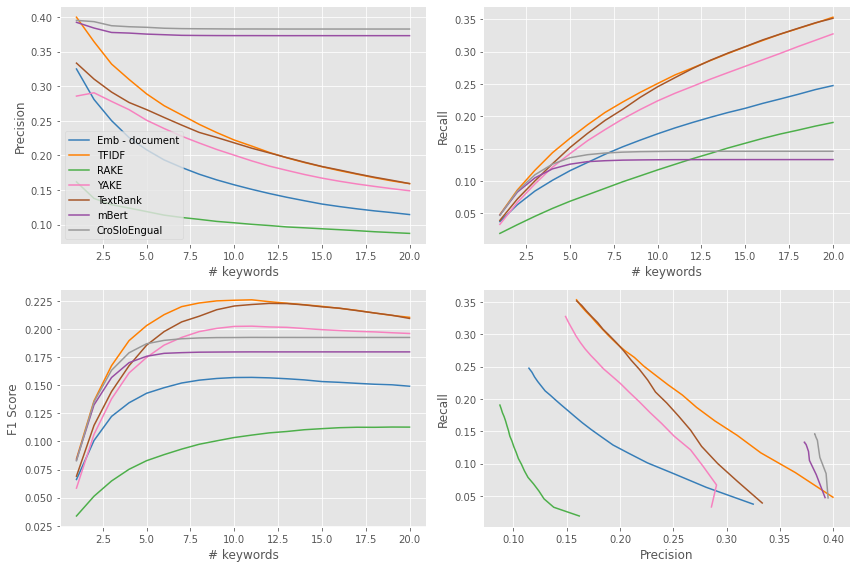

In [13]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _), c in zip(sc, methods, CB_color_cycle):
        plt.plot(range(1, 21), p, label=l, color=c)
    if i == 0:
        plt.legend()
    plt.xlabel("# keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _), c in zip(precisions, recalls, methods, CB_color_cycle):
    plt.plot(p, r, label=l, color=c)
plt.xlabel("Precision")
plt.ylabel("Recall")

plt.tight_layout()

Iz grafov lahko sklepamo, da se na primeru člankov najbolje obnese metoda YAKE!. Sledita TF-IDF in Text Rank. Razlika med YAKE in TF-IDF je na tem korpusu večja kot pri korpusu Schutz2008.

## Most common words

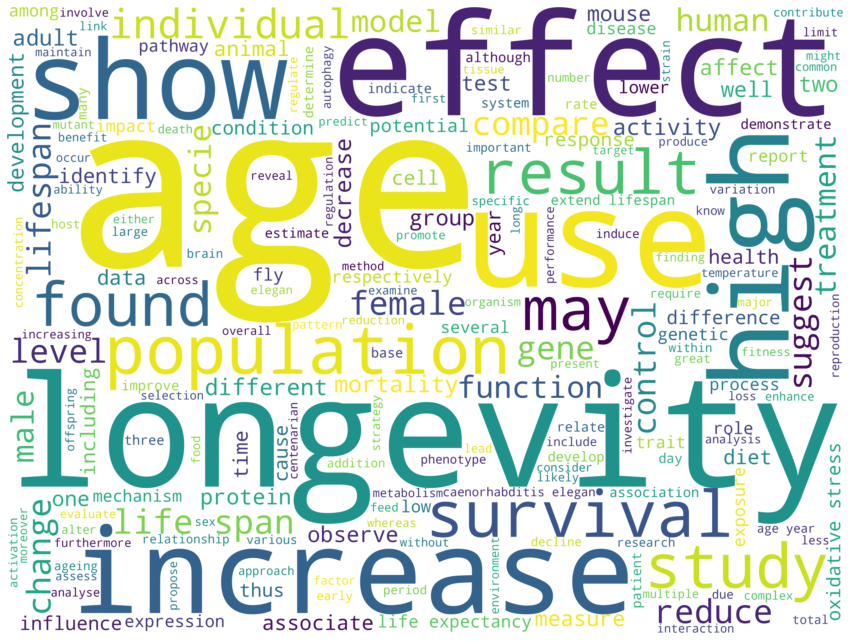

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=4000, height=3000, random_state=0, background_color="white"
).generate(" ".join([t for ts in tokens_list for t in ts]))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");